# Node frequency analysis: HemeThrombKG/HemeKG 2.0

This notebook illustrates the frequency of occurrences of nodes n the hemeThrombKG/HemeKG 2.0. The most commonly occurring nodes are labelled.

In [1]:
from collections import defaultdict
import json
import pandas as pd
import networkx as nx
import urllib.request

import igraph 
import pybel

from network_utils import normalize

/Users/sarahmubeen/Library/Python/3.10/lib/python/site-packages/pybel/struct/operations.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Load HemeThrombKG

In [2]:
review_kg = pybel.from_bel_script('../bel_files/hemeThrombKG.bel')

downloading namespaces:   0%|          | 0/20 [00:00<?, ?it/s]

downloading annotations:   0%|          | 0/11 [00:00<?, ?it/s]

### Load HemeKG

In [3]:
with urllib.request.urlopen('https://raw.githubusercontent.com/hemekg/hemekg/master/hemekg/_cache.bel.nodelink.json') as url:
    data = json.loads(url.read().decode())
    
    heme_kg = pybel.from_nodelink(data)
    

In [4]:
BLACKLIST_FUNCTIONS = ['Complex', 'Composite', 'Reaction', 'RNA']

    
def get_node_stats(kg):
    node_stats = defaultdict(int)
    
    for source, target, _ in kg.edges(data=True):
        
        if source.function not in BLACKLIST_FUNCTIONS: 
            node_stats[source.name] += 1
            
#         elif source.function == "Complex":

#             for member in source.members:
#                 if member.function not in BLACKLIST_FUNCTIONS:
#                     node_stats[member.name] += 1

#         elif source.function == "Reaction":
#             for reactant in source.reactants:
#                 if reactant.function not in BLACKLIST_FUNCTIONS:   
#                     node_stats[reactant.name] += 1

#             for product in source.products: 
#                 if product.function not in BLACKLIST_FUNCTIONS:
#                     node_stats[product.name] += 1
                    
        if target.function not in BLACKLIST_FUNCTIONS:
            node_stats[target.name] += 1
            
#         elif target.function == "Complex":

#             for member in target.members:
#                 if member.function not in BLACKLIST_FUNCTIONS:
#                     node_stats[member.name] += 1

#         elif target.function == "Reaction":
#             for reactant in target.reactants:
#                 if reactant.function not in BLACKLIST_FUNCTIONS:   
#                     node_stats[reactant.name] += 1

#             for product in target.products: 
#                 if product.function not in BLACKLIST_FUNCTIONS:
#                     node_stats[product.name] += 1
        
    return dict(sorted(node_stats.items(), key=lambda item: item[1], reverse=True))
    

In [5]:
abbreviations = {
    'Reactive Oxygen Species': 'ROS',
    'Cell Adhesion Molecules': 'CAMs',
}

def get_node_frequency(kg, node_stats, normalize_vals_dict):
    cc = max(nx.algorithms.components.connected_components(kg.to_undirected()), key=len)

    non_connected = {
        node
        for node in kg
        if node not in cc
    }

    kg.remove_nodes_from(non_connected)

    nodes = []
    names = []
    node_sizes = []

    for node in kg:

        nodes.append(node.as_bel())

        if node.function not in BLACKLIST_FUNCTIONS:
            
            if not node.namespace == "MGI":
            
                if node.name in abbreviations:
                    names.append(abbreviations[node.name])
                else:
                    names.append(node.name)

                node_sizes.append(node_stats[node.name])

        else:
            names.append("")
            node_sizes.append(2)


    labels = []
    norm = []
    
    norm = normalize(
        node_sizes,
        normalize_vals_dict
     )
    
    for name, size in zip(names, norm):

        if size > 6:
            labels.append(name)
        else:
            labels.append('')

    graph = igraph.Graph()
    graph.add_vertices(nodes)

    graph.vs["label"] = labels

    for source, target in kg.edges():

        graph.add_edge(
            source.as_bel(),
            target.as_bel(),
        )

    visual_style = {
        "vertex_size" : norm,
        "vertex_color" : "#009ACD",
        "vertex_frame_color":"#009ACD",
        "vertex_label_size":6, 
        "vertex_label_color":"#5b5b5b",
        "vertex_label_dist": 1,
        "edge_color":"#D3D3D3", 
        "edge_width":0.3,
    }

    return graph, visual_style


### Merge reviewKG and HemeThrombKG

In [6]:
merged_kg = pybel.union([heme_kg, review_kg])

### Render hemeKG 2.0

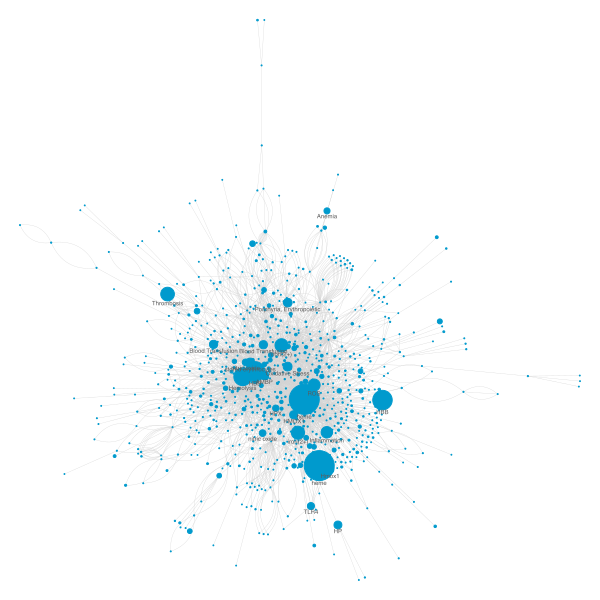

In [7]:
merged_node_stats = get_node_stats(merged_kg)
merged_node_stats['heme'] = 250
merged_node_stats['HBB'] = 160
merged_node_stats['Hemolysis'] = 145
merged_node_stats['Thrombosis'] = 110
        
normalize_vals_dict = {'actual': {'lower': 1, 'upper': 250}, 'desired': {'lower': 1, 'upper': 30}}

graph, visual_style = get_node_frequency(merged_kg, merged_node_stats, normalize_vals_dict)

layout = graph.layout("fr")
igraph.plot(graph, layout=layout, **visual_style)


### Render HemeThrombKG

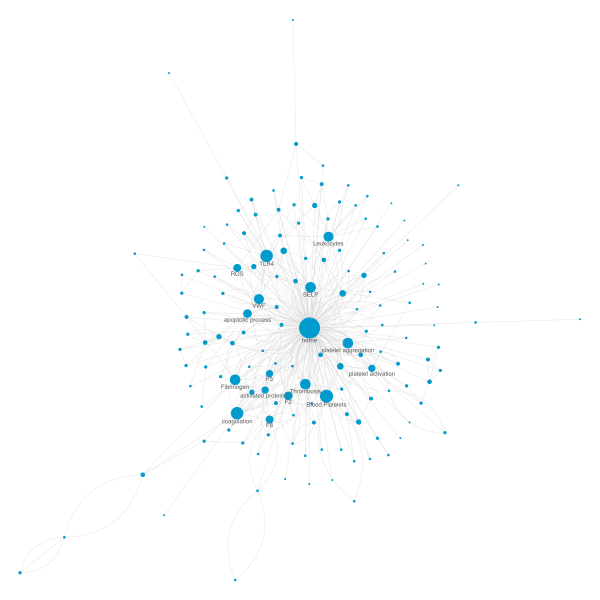

In [8]:
review_node_stats = get_node_stats(review_kg)
review_node_stats['heme'] = 30

normalize_vals_dict = {'actual': {'lower': 1, 'upper': 30}, 'desired': {'lower': 1, 'upper': 20}}
graph, visual_style = get_node_frequency(review_kg, review_node_stats, normalize_vals_dict)

layout = graph.layout("fr")
igraph.plot(graph, layout=layout, **visual_style)
